<a href="https://colab.research.google.com/github/aayushrai/Mask_Recognition/blob/master/model_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
from google.colab import drive
drive.mount('/content/drive/')
!unzip "/content/drive/My Drive/type_of_mask_dataset.zip"

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
Archive:  /content/drive/My Drive/type_of_mask_dataset.zip
replace dataset/hankerchief/with-mask-0.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [0]:
# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import AveragePooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.mobilenet_v2 import preprocess_input
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import os

In [25]:
train_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
train_generator = train_datagen.flow_from_directory(
        '/content/dataset',
        target_size=(224, 224),
        batch_size=32)
validation_generator = test_datagen.flow_from_directory(
        '/content/dataset',
        target_size=(224, 224),
        batch_size=32)

Found 2669 images belonging to 4 classes.
Found 2669 images belonging to 4 classes.


In [26]:
baseModel = MobileNetV2(weights="imagenet", include_top=False,input_tensor=Input(shape=(224, 224, 3)))

In [0]:
# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(128, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(4, activation="softmax")(headModel)

In [0]:
# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

In [0]:
# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

In [30]:
INIT_LR = 1e-4
EPOCHS = 20
BS = 32

print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["accuracy"])

[INFO] compiling model...


In [31]:
# train the head of the network
print("[INFO] training head...")
H = model.fit(
	train_generator,
	steps_per_epoch=124,
	validation_data=validation_generator,
	validation_steps=124,epochs=EPOCHS)

[INFO] training head...
Epoch 1/20
124/124 [==============================] - 27s 219ms/step - loss: 0.8273 - accuracy: 0.6569 - val_loss: 0.3669 - val_accuracy: 0.9035
Epoch 2/20
124/124 [==============================] - 26s 210ms/step - loss: 0.3823 - accuracy: 0.8681 - val_loss: 0.2130 - val_accuracy: 0.9572
Epoch 3/20
124/124 [==============================] - 26s 208ms/step - loss: 0.2685 - accuracy: 0.9145 - val_loss: 0.1508 - val_accuracy: 0.9728
Epoch 4/20
124/124 [==============================] - 26s 207ms/step - loss: 0.2088 - accuracy: 0.9385 - val_loss: 0.1164 - val_accuracy: 0.9785
Epoch 5/20
124/124 [==============================] - 26s 208ms/step - loss: 0.1641 - accuracy: 0.9473 - val_loss: 0.0902 - val_accuracy: 0.9827
Epoch 6/20
124/124 [==============================] - 26s 208ms/step - loss: 0.1385 - accuracy: 0.9602 - val_loss: 0.0718 - val_accuracy: 0.9901
Epoch 7/20
124/124 [==============================] - 26s 208ms/step - loss: 0.1164 - accuracy: 0.9679 - v

In [32]:
print("[INFO] saving mask detector model...")
model.save("mask_type.h5", save_format="h5")

[INFO] saving mask detector model...


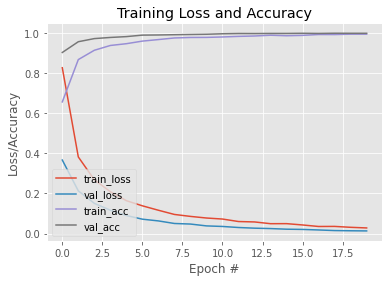

In [33]:
# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot( H.history["loss"], label="train_loss")
plt.plot (H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")